In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pylab as plt


In [2]:
'''
    Dataset
'''
class Dataset():
    def __init__(self, df=None):
        self.items = []
        if df:
            self.add(df)

    def add_df(self, df, source=None):
        items = []
        for row in df[['id', 'subject', 'terms']].values:
            id = row[0]
            subject = row[1]
            terms = [t.strip() for t in row[2].split(',')]
            items.append([source, id, subject, terms])
        self.items.extend(items)

    def add_fn(self, name, fn, columns):
        df = pd.read_csv(fn, sep='\t')
        ds = pd.DataFrame(df[columns].values, columns=['id', 'subject', 'terms'])
        ds.drop_duplicates(['subject', 'terms'], inplace=True)
        ds.dropna(inplace=True)
        self.add_df(ds, name)
        
    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        return self.items[idx]


In [3]:
'''
    Evaluators
'''
import os
import json
import requests

class Evaluator():
    def __init__(self):
        pass

    def eval(self, id, terms):
        pass

'''
    Phen2GeneEval
'''
PHEN2GENE_URL = 'https://f29bio.northeurope.cloudapp.azure.com/api/Phen2Gene/calc?weightModel=sk'

class Phen2GeneEval():
    def __init__(self, url=PHEN2GENE_URL, rows=100):
        self.url = url + F'&rows={rows}'

    def request(self, source, id, hpos):
        source = source or 'common'
        fn = F'_public_case_cache/{source}-{id}.json'
        if os.path.isfile(fn):
            with open(fn, 'r') as fp:
                return json.load(fp)
        resp = requests.post(self.url, json=hpos)
        with open(fn, 'w') as fp:
            json.dump(resp.json(), fp, indent=2)
        return resp.json()

    def validate(self, source, id, subject, terms):
        subject = subject.upper()
        resp = self.request(source, id, terms)
        query = resp['query']
        for term in query:
            status = query[term]['status']
            if status != 'ok':
                print(source, id, term, status, sep='\t')

    def eval(self, source, id, subject, terms):
        subject = subject.upper()
        resp = self.request(source, id, terms)
        ranking = resp['response']
        for item in ranking:
            if item.upper() == subject:
                return ranking[subject]['rank']
        return 1000

'''
    PhenolyzerEval
'''
class PhenolyzerEval():
    def __init__(self):
        pass

    def eval(self, source, id, subject, terms):
        fn = os.path.join('_phenolyzer', source, F'{id}.json')
        with open(fn, 'r') as fp:
            ranking = json.load(fp)
        subject = subject.upper()
        n = 1
        for item in ranking:
            if item['Name'].upper() == subject:
                return n
            n += 1
        return 1000
    

In [4]:
'''
    Load Dataset
'''
dataset = Dataset()

dataset.add_fn('rao', '_public_case_data/rao-testCases_rarediseases_full.tsv', ['Internal ID', 'Gene', 'Clinical Indication and Phenotype (HPO)'])
dataset.add_fn('kleyner', '_public_case_data/kleyner-testCases_rarediseases_full.tsv', ['Internal ID', 'Gene', 'Clinical Indication and Phenotype (HPO)'])
dataset.add_fn('cipriani', '_public_case_data/cipriani-cases.tsv', ['Patient_identifier', 'Gene', 'Clinical_diagnosis_label'])

for row in list(dataset)[:4]:
    print(*row, sep='\t')
    

rao	TCS001	EP300	['HP:0010301', 'HP:0000252', 'HP:0001263']
rao	TCS003	SMARCB1	['HP:0001263', 'HP:0002650', 'HP:0001382', 'HP:0002079', 'HP:0001999']
rao	TCS004	LARP7	['HP:0001263', 'HP:0004322', 'HP:0100255']
rao	TCS005	KAT6B	['HP:0007105']


In [43]:
'''
    Plot
'''
def plot(d, title=None, max_rank=25):
    lists = sorted(d.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    if max_rank >= 0:
        x = x[:max_rank-1]
        y = y[:max_rank-1]
    y = np.cumsum(y)
    if title:
        fig = plt.figure()
        fig.suptitle(title)
        plt.plot(x, y)
        return fig
    else:
        return plt.plot(x, y)

{1: 7, 2: 9, 3: 6, 4: 5, 5: 6, 6: 4, 7: 2, 8: 4, 9: 4, 10: 2, 11: 3, 12: 2, 13: 2, 14: 2, 15: 4, 16: 6, 17: 1, 18: 1, 19: 4, 20: 1, 21: 1, 22: 3, 23: 1, 24: 1, 25: 4, 26: 3, 28: 1, 29: 2, 30: 1, 33: 3, 34: 1, 36: 2, 37: 1, 38: 2, 39: 1, 40: 1, 41: 4, 43: 1, 44: 2, 45: 1, 46: 3, 47: 1, 51: 1, 52: 2, 55: 2, 56: 1, 57: 1, 58: 3, 59: 1, 60: 1, 61: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 69: 1, 70: 2, 71: 1, 72: 1, 76: 1, 78: 1, 79: 1, 81: 1, 83: 1, 84: 1, 85: 1, 89: 1, 93: 2, 94: 3, 95: 2, 96: 3, 97: 161}


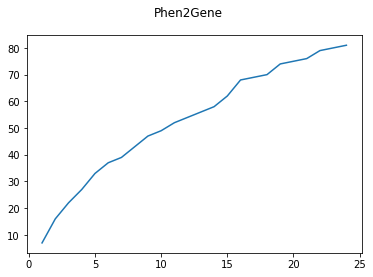

In [49]:
'''
    Eval Phen2Gene
'''
phen2gene = Phen2GeneEval()

ranks = list()
for source, id, subject, terms in dataset:
    ranks.append(phen2gene.eval(source, id, subject, terms))
temp_freq, temp_keys = np.histogram(ranks, bins=np.unique(ranks))
rank_phen2gene = dict(zip(temp_keys, temp_freq))
print(rank_phen2gene)

plot(rank_phen2gene, 'Phen2Gene', 25)
plt.show()


{1: 7, 2: 1, 3: 9, 4: 6, 5: 4, 6: 7, 7: 4, 8: 4, 9: 1, 10: 2, 12: 1, 14: 4, 15: 2, 16: 2, 17: 1, 18: 2, 20: 1, 21: 1, 22: 3, 23: 3, 24: 1, 26: 1, 27: 2, 28: 1, 29: 3, 30: 1, 31: 2, 32: 1, 33: 3, 34: 1, 35: 1, 36: 1, 37: 2, 38: 1, 41: 3, 42: 1, 43: 4, 44: 2, 45: 1, 47: 3, 49: 2, 51: 1, 52: 2, 54: 1, 58: 2, 59: 1, 60: 2, 61: 1, 63: 2, 64: 2, 65: 2, 66: 2, 67: 3, 68: 1, 71: 1, 72: 1, 73: 1, 74: 1, 80: 1, 81: 1, 82: 1, 83: 1, 88: 1, 90: 2, 91: 1, 92: 2, 94: 1, 96: 1, 97: 1, 99: 1, 102: 1, 107: 1, 111: 1, 114: 1, 117: 1, 118: 2, 119: 2, 121: 1, 122: 1, 125: 1, 126: 1, 131: 2, 134: 1, 139: 1, 140: 4, 141: 1, 142: 1, 145: 1, 149: 1, 158: 1, 162: 1, 165: 1, 173: 1, 175: 2, 182: 2, 184: 1, 185: 1, 186: 1, 189: 1, 192: 1, 195: 1, 198: 1, 204: 1, 206: 1, 214: 1, 215: 1, 227: 1, 230: 1, 232: 1, 248: 1, 256: 1, 272: 1, 278: 1, 282: 1, 283: 1, 286: 1, 287: 1, 289: 1, 296: 1, 298: 1, 301: 1, 321: 1, 336: 1, 355: 1, 373: 1, 383: 1, 397: 1, 402: 1, 409: 1, 422: 1, 424: 1, 433: 1, 462: 1, 498: 1, 503: 1

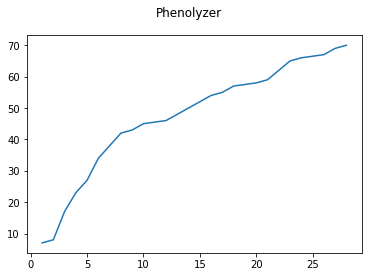

In [50]:
'''
    Eval Phenolyzer
'''
phenolyzer = PhenolyzerEval()

ranks = list()
for source, id, subject, terms in dataset:
    ranks.append(phenolyzer.eval(source, id, subject, terms))
temp_freq, temp_keys = np.histogram(ranks, bins=np.unique(ranks))
rank_phenolyzer = dict(zip(temp_keys, temp_freq))
print(rank_phenolyzer)

plot(rank_phenolyzer, 'Phenolyzer', 25)
plt.show()


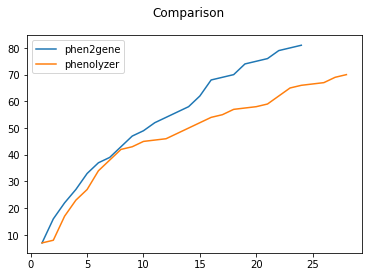

In [51]:
fig = plt.figure()
fig.suptitle('Comparison')
a, = plot(rank_phen2gene)
b, = plot(rank_phenolyzer)
plt.legend([a, b], ['phen2gene', 'phenolyzer'])

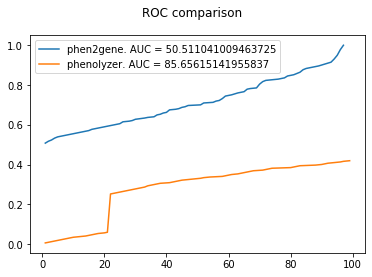

In [68]:
'''
    Plot ROC figure
'''
def get_roc(y):
    y = np.cumsum(y[::-1])/np.sum(y)
    return y, np.sum(y)
    
def plot_roc(d, title=None, max_rank=None):
    lists = sorted(d.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    y, auc = get_roc(y)
    if max_rank is not None:
        x = [i for i in x if i <= max_rank]
        y = y[:len(x)]
    if title:
        fig = plt.figure()
        fig.suptitle(title)
        plt.plot(x, y)
        return fig
    else:
        return plt.plot(x, y)

fig = plt.figure()
fig.suptitle('ROC comparison')
a, = plot_roc(rank_phen2gene, max_rank=100)
b, = plot_roc(rank_phenolyzer, max_rank=100)
plt.legend([a, b], ['phen2gene', 'phenolyzer'])